In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#helps unboxing the blackbox
import shap

import imblearn as imb
from imblearn.over_sampling import SMOTE

In [5]:
# --- Model selection utilities ---
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# --- Preprocessing tools ---
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# --- Classification models ---
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
# --- Evaluation metrics ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    auc,
)

from sklearn.inspection import permutation_importance


## 1. Define Features and Labels

In [6]:
df = pd.read_csv('../../data/diabetes_nnorm.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']

## 2. Nested Crossvalidation
outer loop: model evaluation, inner loop: hyperparameter tuning


--- Working on fold 1 ---


C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 1 — F1 score: 0.6885
  Accuracy: 0.7532
  Precision: 0.6176
  Recall: 0.7778
  ROC AUC: 0.8121
  Best n_neighbors: 9
  Best weights: distance
  Best metric: manhattan

--- Working on fold 2 ---


C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 2 — F1 score: 0.6372
  Accuracy: 0.7338
  Precision: 0.6102
  Recall: 0.6667
  ROC AUC: 0.8058
  Best n_neighbors: 5
  Best weights: distance
  Best metric: euclidean

--- Working on fold 3 ---


C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 3 — F1 score: 0.6341
  Accuracy: 0.7078
  Precision: 0.5652
  Recall: 0.7222
  ROC AUC: 0.7716
  Best n_neighbors: 5
  Best weights: distance
  Best metric: euclidean

--- Working on fold 4 ---


C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 4 — F1 score: 0.6261
  Accuracy: 0.7190
  Precision: 0.5806
  Recall: 0.6792
  ROC AUC: 0.7843
  Best n_neighbors: 5
  Best weights: distance
  Best metric: euclidean

--- Working on fold 5 ---


C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 5 — F1 score: 0.6290
  Accuracy: 0.6993
  Precision: 0.5493
  Recall: 0.7358
  ROC AUC: 0.7411
  Best n_neighbors: 5
  Best weights: distance
  Best metric: manhattan


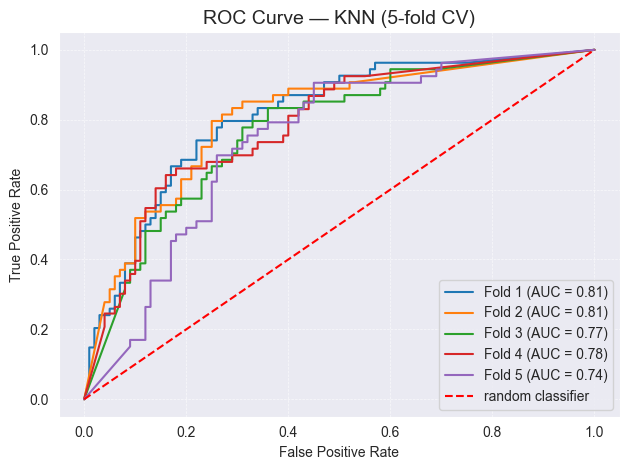

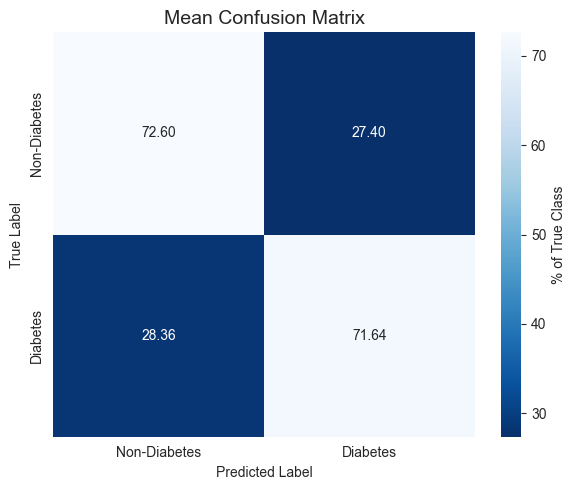

In [26]:
# Define cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
parameters = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize storage
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
models = []
f1_scores = []
roc_curves = []
conf_matrices = []
fold = 1

# Cross-validation loop
for train_index, test_index in cv.split(X, y):
    print(f'\n--- Working on fold {fold} ---')

    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to training data
    smote = SMOTE(random_state=fold)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Grid search on scaled, resampled training data
    knn = KNeighborsClassifier()
    clf_GS = GridSearchCV(knn, parameters, cv=5, scoring='f1')
    clf_GS.fit(X_train_scaled, y_train_resampled)

    # Evaluate best model
    best_model = clf_GS.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    metrics['roc_auc'].append(roc_auc)
    roc_curves.append((fpr, tpr, roc_auc, fold))
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Fold {fold} — F1 score: {f1:.4f}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print('  Best n_neighbors:', best_model.get_params()['n_neighbors'])
    print('  Best weights:', best_model.get_params()['weights'])
    print('  Best metric:', best_model.get_params()['metric'])

    # Store results
    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    f1_scores.append(f1)
    models.append(best_model)

    # Store confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    fold += 1

# Identify best model
best_index = f1_scores.index(max(f1_scores))
best_model_overall = models[best_index]

# Reconstruct best model for export/deployment
params = best_model_overall.get_params()
b_model = KNeighborsClassifier(
    n_neighbors=params["n_neighbors"],
    weights=params["weights"],
    metric=params["metric"]
)

# Final ROC plot
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — KNN (5-fold CV)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()  # FLUSH the figure

# ---- Confusion Matrix Plot ----
plt.close('all')
plt.figure(figsize=(6, 5))  # NEW FIGURE!
mean_cm = np.mean(conf_matrices, axis=0)
mean_cm_percent = 100 * mean_cm / mean_cm.sum(axis=1, keepdims=True)  # Normalize to % of true class

# Define readable class labels
class_labels = ['Non-Diabetes', 'Diabetes']

sns.heatmap(mean_cm_percent, annot=True, fmt='.2f', cmap='Blues_r',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': '% of True Class'})
plt.title('Mean Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 3. Evaluation metrics

In [34]:
# Create summary in screenshot format
summary = {
    'Model': ['KNN'],
    'F1_Mean': [np.mean(metrics['f1'])],
    'F1_Std': [np.std(metrics['f1'])],
    'Recall_Mean': [np.mean(metrics['recall'])],
    'Recall_Std': [np.std(metrics['recall'])],
    'Precision_Mean': [np.mean(metrics['precision'])],
    'Precision_Std': [np.std(metrics['precision'])],
    'Accuracy_Mean': [np.mean(metrics['accuracy'])],
    'Accuracy_Std': [np.std(metrics['accuracy'])],
    'ROC_AUC_Mean': [np.mean(metrics['roc_auc'])],
    'ROC_AUC_Std': [np.std(metrics['roc_auc'])],
}

# Convert to DataFrame and export
summary_df = pd.DataFrame(summary)
import os

# Ensure the directory exists
os.makedirs('Data_Processing', exist_ok=True)

# Then save the CSV
summary_df.to_csv('Data_Processing/knn_summary_metrics.csv', index=False)

In [38]:
# === Reuse best model parameters identified from nested CV ===
best_params = b_model.get_params()
knn_final = KNeighborsClassifier(**best_params)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Apply SMOTE ===
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# === Standard scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# === Train final model ===
knn_final.fit(X_train_scaled, y_train_resampled)


# Scale background and test set

# Wrap KNN to return probability for class 1 only
def knn_predict_class1(X):
    return knn_final.predict_proba(X)[:, 1]

# Create KernelExplainer
explainer = shap.KernelExplainer(knn_predict_class1, X_train_scaled)

# Compute SHAP values (returns shape: n_samples x n_features)
shap_values = explainer.shap_values(X_test_scaled)
import os

# Ensure 'output/' directory exists
os.makedirs('output', exist_ok=True)
# Plot summary with unscaled input for interpretability
X_test_df = pd.DataFrame(X_test, columns=X.columns)
shap.summary_plot(shap_values, X_test, show=False)  # <-- disable auto-show
plt.savefig("output/shap_summary_plot.png", bbox_inches="tight", dpi=300)
plt.close()  # Good practice in scripts


C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 154/154 [05:11<00:00,  2.03s/it]
